### Re-State Our Goal
*Goal:* We want to use Shaggy's dataset to train a male/female butterfly classifier. And we need to describe the dataset work that Shaggy's done.

### State Our Assumptions About the Dataset
When we started, our assumptions were:
- Shaggy's dataset is derived from Kydoimos
- No changes have been made to the image data content
- No images have been added or removed
- Each component of Shaggy's dataset can be linked to its corresponding component into the source dataset (provenance is intact)
- Test/train splits are done appropriately

Apparently, some, or all of these assumptions weren't accurate.

### Make an Intermediate Goal
*Goal:* We want to see if we can re-link Shaggy's work to the original dataset.</br>
 To test which of our assumptions are off, let's do the following:
1. Download the original/upstream/source dataset (Kydoimos)
2. Load Shaggy's dataset
3. Run MD5 checksums on all images in Kydoimos and Shaggy's dataset
4. Merge on MD5

In [16]:
# All imports
import pandas as pd
from datasets import load_dataset
import os
import hashlib
import io
from io import BytesIO
from PIL import Image, UnidentifiedImageError
from PIL.TiffTags import TAGS
import numpy as np

## 1. Download the original/upstream/source dataset (Kydoimos) 

In [5]:
dataset_path = "johnbradley/Kydoimos"
kydoimos = load_dataset(dataset_path)

Resolving data files:   0%|          | 0/111 [00:00<?, ?it/s]

### Explore the upstream dataset

In [6]:
kydoimos

DatasetDict({
    train: Dataset({
        features: ['image', 'id', 'NHM specimen number', 'View', 'Species', 'Subspecies', 'Sex', 'Type Status'],
        num_rows: 110
    })
})

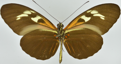

In [7]:
kydoimos['train']['image'][1]

In [8]:
print(kydoimos['train']['image'][1])

<PIL.TiffImagePlugin.TiffImageFile image mode=RGB size=121x64 at 0x1CEA0B9D2B0>


### Load the upstream dataset into a Pandas dataframe for simpler exploration

In [9]:
kydoimos_df = pd.DataFrame(kydoimos['train'])

In [10]:
kydoimos_df.head(3)

,image,id,NHM specimen number,View,Species,Subspecies,Sex,Type Status
0,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000000,10428329,dorsal,melpomene,thelxiopeia,male,None
1,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000001,10428329,ventral,melpomene,thelxiopeia,male,None
2,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000002,10428331,dorsal,melpomene,thelxiopeia,female,None


In [11]:
kydoimos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image                110 non-null    object
 1   id                   110 non-null    object
 2   NHM specimen number  110 non-null    int64 
 3   View                 110 non-null    object
 4   Species              110 non-null    object
 5   Subspecies           110 non-null    object
 6   Sex                  110 non-null    object
 7   Type Status          2 non-null      object
dtypes: int64(1), object(7)
memory usage: 7.0+ KB


In [12]:
kydoimos_df.drop(columns=['image']).nunique()

id                     110
NHM specimen number     38
View                     4
Species                  2
Subspecies               6
Sex                      4
Type Status              1
dtype: int64

## 2. Load Shaggy's dataset

In [13]:
shaggy_dir = "../Shaggy/"
shaggy_df = pd.read_csv(os.path.join(shaggy_dir, 'metadata.csv'), encoding='utf-8', low_memory=False)

In [15]:
shaggy_df.head(3)

,file_name,Sex,split
0,images/melpomene_26.tif,female,train
1,images/melpomene_16.tif,female,train
2,images/melpomene_18.tif,female,train


## 3. Run MD5 checksums on all images in Kydoimos and Shaggy's dataset

## 4. Merge the datasets on MD5 to link them together

### Zoinks